# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Imports

In [3]:
import datahandler
import plotter
import utils

import matplotlib.pyplot as plt
import matplotlib.pyplot
import matplotlib.dates
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.patches as mpatches
import scipy.stats
import folium
import seaborn as sns
import geopandas as gpd
import selenium
import PIL.Image
import io
import math
import folium.features
import folium.plugins


# Constants

In [4]:
DEPOT_INDEX_TO_COLOR = {
    0: "#e6194B",
    1: "#3cb44b",
    2: "#ffe119",
    3: "#4363d8",
    4: "#f58231",
    5: "#911eb4",
    6: "#42d4f4",
    7: "#f032e6",
    8: "#bfef45",
    9: "#fabed4",
    10: "#469990",
    11: "#dcbeff",
    12: "#9A6324",
    13: "#a9a9a9",
    14: "#800000",
    15: "#aaffc3",
    16: "#808000",
    17: "#ffd8b1",
    18: "#000075",
}


In [5]:
data_preprocessor = datahandler.DataPreprocessorOUS_V2()
data_preprocessor.execute()

data_loader = datahandler.DataLoader(datahandler.DataPreprocessorOUS_V2)
data_loader.execute(clean=False, processed=False, enhanced=True)


Cleaning dataset: 100%|██████████| 2/2 [00:00<00:00, 3990.77it/s]


Loading dataset: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


# Methods


In [6]:
def add_info(dataframe: pd.DataFrame) -> pd.DataFrame:
    historic_steps = {
        "duration_incident_creation": ("time_call_received", "time_incident_created"),
        "duration_resource_appointment": ("time_incident_created", "time_resource_appointed"),
        "duration_resource_preparing_departure": ("time_resource_appointed", "time_ambulance_dispatch_to_scene"),
        "duration_dispatching_to_scene": ("time_ambulance_dispatch_to_scene", "time_ambulance_arrived_at_scene"),
        "duration_at_scene": ("time_ambulance_arrived_at_scene", "time_ambulance_dispatch_to_hospital", "time_ambulance_available"),
        "duration_dispatching_to_hospital": ("time_ambulance_dispatch_to_hospital", "time_ambulance_arrived_at_hospital"),
        "duration_at_hospital": ("time_ambulance_arrived_at_hospital", "time_ambulance_available")
    }

    for step, times in historic_steps.items():
        if len(times) == 3:
            dataframe.loc[dataframe[times[1]].isna(), step] = (dataframe[times[2]] - dataframe[times[0]]).dt.total_seconds()
            dataframe.loc[~dataframe[times[1]].isna(), step] = (dataframe[times[1]] - dataframe[times[0]]).dt.total_seconds()
        else:
            dataframe[step] = (dataframe[times[1]] - dataframe[times[0]]).dt.total_seconds()
    
    response_time_cols = [
        'duration_incident_creation',
        'duration_resource_appointment',
        'duration_resource_preparing_departure',
        'duration_dispatching_to_scene'
    ]
    dataframe['total_response_time'] = dataframe[response_time_cols].sum(axis=1)

    dataframe["complied"] = np.nan
    # Define the criteria for response times
    criteria = {
        ('A', True): 12 * 60,
        ('A', False): 25 * 60,
        ('H', True): 30 * 60,
        ('H', False): 40 * 60
    }

    for (triage, urban), group in dataframe.groupby(['triage_impression_during_call', 'urban_settlement_ssb']):
        limit = criteria.get((triage, urban))
        if limit is not None:
            dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit

    return dataframe


In [7]:
def plot_time_distribution(dataframe: pd.DataFrame):
    # Extract hours, minutes, and seconds
    dataframe['hour'] = dataframe['time_call_received'].dt.hour
    dataframe['minute'] = dataframe['time_call_received'].dt.minute
    dataframe['second'] = dataframe['time_call_received'].dt.second

    # Set up the figure and axes
    fig = plt.figure(figsize=(9, 9))
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)  # Hour plot
    ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)  # Minute plot
    ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)  # Second plot
    ax_legend = plt.subplot2grid((2, 2), (0, 1), colspan=2, rowspan=2)  # Legend plot

    triage_to_name = {
        "A": "Acute",
        "H": "Urgent",
        "V1": "Non-Urgent"
    }

    # Time components and axes
    time_components = ['hour', 'minute', 'second']
    axs = [ax1, ax2, ax3]
    titles = ["Hour", "Minute", "Second"]

    lines = []  # To store line handles for the legend
    labels = []  # To store labels for the legend

    for ax, component in zip(axs, time_components):
        # For each category in triage impressions
        for category in ["A", "H", "V1"]:
            # Filter data by triage impression and calculate normalized count
            subset = dataframe[dataframe['triage_impression_during_call'] == category]
            count_series = subset[component].value_counts(normalize=True).sort_index() * 100

            # Plot and collect line handles and labels for legend
            line, = ax.plot(count_series.index, count_series.values)
            if len(labels) < 3:
                lines.append(line)
                labels.append(f"{triage_to_name[category]}")

        # add total
        count_series = dataframe[component].value_counts(normalize=True).sort_index() * 100
        line, = ax.plot(count_series.index, count_series.values, "--", color="black", alpha=0.8)
        if len(labels) < 4:
            lines.append(line)
            labels.append(f"All")

        # Set title, labels
        ax.set_title(f"Probability Distribution of {titles[time_components.index(component)]}", fontdict=constants.FONT_PROPERTIES_SUB_HEADER)
        ax.set_xlabel(titles[time_components.index(component)])
        if component != "second":
            ax.set_ylabel("Probability (%)")
        
        # Set xticks appropriately
        if component == 'hour':
            ax.set_xticks(range(0, 24))
            ax.set_xlim((0, 23))
            ax.set_ylim(top=10)
        else:
            ax.set_xticks(range(0, 60, 5))
            ax.set_xlim((0, 59))
            ax.set_ylim(top=2.5)
        
        ax.set_ylim(bottom=0)

    # Configure legend plot
    ax_legend.axis('off')
    ax_legend.legend(lines, labels, loc='upper right', title="Triage Impression")

    title = "Probability Distribution of Emergency Call by Triage Impression"

    fig.suptitle(title, **constants.FONT_PROPERTIES_HEADER)

    plt.tight_layout()

    plt.savefig(os.path.join(constants.PROJECT_DIRECTORY_PATH, "source", "analysis", "plots", title.replace("\n", " ") + ".png"), dpi=300, bbox_inches='tight')
    
    plt.show()


In [8]:
def plot_cancellation_distribution(dataframe: pd.DataFrame):
    # Determine whether the ambulance dispatch was cancelled based on the field being NaN
    dataframe["cancelled"] = dataframe["time_ambulance_dispatch_to_hospital"].isna()
    # Extract the hour from the call received time
    dataframe['hour'] = dataframe['time_call_received'].dt.hour

    # Filter the data to include only cancellations
    cancelled_data = dataframe[dataframe["cancelled"]]

    # Define custom labels for triage impressions
    triage_to_name = {
        "A": "Acute",
        "H": "Urgent",
        "V1": "Non-Urgent"
    }

    # Group by hour and triage impression, then calculate the probability of cancellation
    cancellation_probs = cancelled_data.groupby(['hour', 'triage_impression_during_call']).size()
    total_counts = dataframe.groupby(['hour', 'triage_impression_during_call']).size()
    cancellation_probs = (cancellation_probs / total_counts).unstack().fillna(0) * 100

    # Plot setup
    fig, ax = plt.subplots(figsize=(9, 6))  # Adjusted figure size to accommodate the legend

    # Plotting each triage category
    lines = cancellation_probs.plot(ax=ax, marker='o')

    # Highlight day shift hours with a different background color
    ax.axvspan(7, 19, color='lightgray', alpha=0.5, label='Day Shift')

    # Set plot titles and labels
    title = "Cancellation Probability Distribution by Triage Impression"

    ax.set_title(title, fontdict=constants.FONT_PROPERTIES_SUB_HEADER)
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Probability (%)")
    ax.set_xticks(range(24))
    ax.set_xlim((0, 23))
    ax.set_ylim(bottom=0)

    # Show grid
    ax.grid(True)

    # Modify legend with custom labels
    legend_labels = [triage_to_name.get(label, label) for label in cancellation_probs.columns]
    # Position legend outside the plot area on the right
    ax.legend(legend_labels + ['Day Shift'], title="Triage Impression", loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()

    plt.savefig(os.path.join(constants.PROJECT_DIRECTORY_PATH, "source", "analysis", "plots", title.replace("\n", " ") + ".png"), dpi=300, bbox_inches='tight')

    plt.show()


In [9]:
def plot_incident_spatial_heatmap(dataframe: pd.DataFrame):
    # Define custom labels for triage impressions
    triage_to_name = {
        "A": "Acute",
        "H": "Urgent",
        "V1": "Non-Urgent"
    }

    # Calculate center and bounds for the map
    sw = dataframe[['latitude', 'longitude']].min().values.tolist()
    ne = dataframe[['latitude', 'longitude']].max().values.tolist()
    center = dataframe[['latitude', 'longitude']].mean().values.tolist()

    # Define shifts
    dataframe['shift'] = 'Night Shift'  # Initialize all records as night shift
    # Define day shift hours
    dataframe.loc[dataframe['time_call_received'].dt.hour.between(7, 18), 'shift'] = 'Day Shift'

    # Group data by triage category and shift
    triage_categories = ["A", "H", "V1"]
    shifts = ['Day Shift', 'Night Shift']
    images = []

    for shift in shifts:
        for triage in triage_categories:
            filtered_df = dataframe[(dataframe['triage_impression_during_call'] == triage) & (dataframe['shift'] == shift)]

            # Frequency of each grid_id in this category
            grid_id_count = filtered_df["grid_id"].value_counts()
            grid_id_count_log = np.log1p(grid_id_count)  # Log transform the counts
            norm = plt.Normalize(grid_id_count_log.min(), grid_id_count_log.max())
            colormap = matplotlib.colormaps["viridis"]

            # Create map
            m = folium.Map(location=center, zoom_start=12)
            CartoDB_PositronNoLabels = folium.TileLayer(
                tiles='https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',
                attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
                subdomains='abcd',
                max_zoom=20,
                name='CartoDB Positron No Labels'
            )
            CartoDB_PositronNoLabels.add_to(m)

            # Add polygons
            for grid_id, count in grid_id_count_log.items():
                x, y = utils.id_to_utm(grid_id)  # Conversion function to be defined
                polygon_coords = utils.get_cell_corners(x, y)  # Conversion function to be defined
                color = colormap(norm(count))
                folium.Polygon(
                    locations=polygon_coords,
                    color=None,  # Optional: set the boundary color
                    fill=True,
                    fill_color=matplotlib.colors.rgb2hex(color),
                    fill_opacity=0.7
                ).add_to(m)

            m.fit_bounds([sw, ne])

            # Render map to PNG image
            img_data = m._to_png()
            img = PIL.Image.open(io.BytesIO(img_data))
            sides_crop = 540
            top_crop = 180
            img = img.crop((sides_crop, top_crop, img.width - sides_crop, img.height - top_crop))
            images.append((img, f"{triage_to_name[triage]}", f"{shift}"))

    # Plotting the images in subplots organized by shifts
    rows = len(shifts)
    cols = len(triage_categories)
    fig, axs = plt.subplots(rows, cols, figsize=(12, 10))

    for idx, (img, triage, shift) in enumerate(images):
        ax = axs[idx // cols, idx % cols]
        ax.imshow(img)
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks
        ax.spines['top'].set_visible(False)  # Hide the top spine
        ax.spines['right'].set_visible(False)  # Hide the right spine
        ax.spines['left'].set_visible(False)  # Hide the left spine
        ax.spines['bottom'].set_visible(False)  # Hide the bottom spine

        if shift == 'Day Shift':
            ax.set_title(triage, fontdict=constants.FONT_PROPERTIES_SUB_HEADER)
        if triage == "Acute":
            ax.set_ylabel(shift)

    title = "Spatial Distribution of Incident Frequencies by Triage Category and Shift"

    fig.suptitle(title, **constants.FONT_PROPERTIES_HEADER)

    plt.tight_layout()

    plt.savefig(os.path.join(constants.PROJECT_DIRECTORY_PATH, "source", "analysis", "plots", title.replace("\n", " ") + ".png"), dpi=300, bbox_inches='tight')

    plt.show()


In [10]:
def plot_cluster(dataframe: pd.DataFrame):
    dataframe_depots = data_preprocessor.load_enhanced_depots_dataframe()

    grid_count = dataframe["grid_id"].value_counts()

    grid_id_to_depot = {grid_id: -1 for grid_id, _ in grid_count.items()}
    depot_to_urban = {depot_index: (0, 0, 0, 0) for depot_index in list(range(19))}

    split_depots = [4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 18]

    for grid_id, _ in grid_id_to_depot.items():
        min_distance = float('inf')
        closest_depot_index = -1

        cell_utm = utils.id_to_utm(grid_id)
        cell_utm = (cell_utm[0] + 500, cell_utm[1] + 500)

        for depot_index, depot in dataframe_depots.iterrows():
            if (depot["type"] != "Depot" and depot["type"] != "Beredskapspunkt"):
                continue

            depot_utm = (depot["x"] + 500, depot["y"] + 500)

            distance = math.dist(cell_utm, depot_utm)

            if (closest_depot_index == -1 or distance < min_distance):
                closest_depot_index = depot_index
                min_distance = distance
        
        grid_id_to_depot[grid_id] = closest_depot_index

        urban = 0
        rural = 0
        if (dataframe["urban_settlement_ssb"].loc[(dataframe['grid_id'] == grid_id).idxmax()]):
            urban = 1
        else:
            rural = 1
        
        complied = 0
        if (dataframe["complied"].loc[(dataframe['grid_id'] == grid_id).idxmax()]):
            complied = 1

        depot_to_urban[closest_depot_index] = (
            depot_to_urban[closest_depot_index][0] + urban,
            depot_to_urban[closest_depot_index][1] + rural,
            depot_to_urban[closest_depot_index][2] + complied,
            depot_to_urban[closest_depot_index][3] + 1
        )
    
    # Calculate center and bounds for the map
    sw = dataframe[['latitude', 'longitude']].min().values.tolist()
    ne = dataframe[['latitude', 'longitude']].max().values.tolist()
    center = dataframe[['latitude', 'longitude']].mean().values.tolist()

    images = []

    # Create map
    m = folium.Map(location=center, zoom_start=12)
    CartoDB_PositronNoLabels = folium.TileLayer(
        tiles='https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',
        attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
        subdomains='abcd',
        max_zoom=20,
        name='CartoDB Positron No Labels'
    )
    CartoDB_PositronNoLabels.add_to(m)

    # Add polygons
    for grid_id, depot_index in grid_id_to_depot.items():
        x, y = utils.id_to_utm(grid_id)
        polygon_coords = utils.get_cell_corners(x, y)
        folium.Polygon(
            locations=polygon_coords,
            color=None,
            fill=True,
            fill_color=DEPOT_INDEX_TO_COLOR[depot_index],
            fill_opacity=0.6
        ).add_to(m)

    for depot_index in list(range(19)):
        if depot_index in split_depots:
            continue

        text = folium.Marker(
            location=(
                dataframe_depots["latitude"].iloc[depot_index],
                dataframe_depots["longitude"].iloc[depot_index]
            ),
            icon=folium.features.DivIcon(
                icon_size=(30, 20),
                icon_anchor=(15, 0),
                html='''
                    <div style="width: 30px; height: 20px; position: relative; font-size: 9pt; color: black; text-shadow: 
                        -1px -1px 0 #fff, 1px -1px 0 #fff, -1px 1px 0 #fff, 1px 1px 0 #fff;
                        display: flex; flex-direction: column; align-items: center; justify-content: flex-start;">
                        <div style="width: 4px; height: 4px; background-color: black; border-radius: 50%; 
                            margin-top: 2px;"></div>  <!-- Black dot at the top -->
                        <div style="position: absolute; bottom: -2px; text-align: center; width: 100%;">{label}</div> <!-- Text positioned below -->
                    </div>
                '''.format(label=dataframe_depots["name"].iloc[depot_index])
            )
        )
        text.add_to(m)

    m.fit_bounds([sw, ne])

    # Render map to PNG image
    img_data = m._to_png()
    img = PIL.Image.open(io.BytesIO(img_data))
    sides_crop = 540
    top_crop = 180
    img = img.crop((sides_crop, top_crop, img.width - sides_crop, img.height - top_crop))
    images.append((img, "Oslo and Akershus"))



    # map of oslo
    center = [59.911889, 10.745541]
    m = folium.Map(location=center, zoom_start=10)
    CartoDB_PositronNoLabels = folium.TileLayer(
        tiles='https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',
        attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
        subdomains='abcd',
        max_zoom=20,
        name='CartoDB Positron No Labels'
    )
    CartoDB_PositronNoLabels.add_to(m)

    # Add polygons
    for grid_id, depot_index in grid_id_to_depot.items():
        x, y = utils.id_to_utm(grid_id)
        polygon_coords = utils.get_cell_corners(x, y)
        folium.Polygon(
            locations=polygon_coords,
            color=None,
            fill=True,
            fill_color=DEPOT_INDEX_TO_COLOR[depot_index],
            fill_opacity=0.6
        ).add_to(m)

    for depot_index in list(range(19)):
        if depot_index in split_depots:
            text = folium.Marker(
                location=(
                    dataframe_depots["latitude"].iloc[depot_index],
                    dataframe_depots["longitude"].iloc[depot_index]
                ),
                icon=folium.features.DivIcon(
                    icon_size=(60, 40),
                    icon_anchor=(30, 0),
                    html='''
                        <div style="width: 60px; height: 40px; position: relative; font-size: 18pt; color: black; text-shadow: 
                            -1px -1px 0 #fff, 1px -1px 0 #fff, -1px 1px 0 #fff, 1px 1px 0 #fff;
                            display: flex; flex-direction: column; align-items: center; justify-content: flex-start;">
                            <div style="width: 8px; height: 8px; background-color: black; border-radius: 50%; 
                                margin-top: 4px;"></div>  <!-- Larger black dot at the top -->
                            <div style="position: absolute; bottom: -4px; text-align: center; width: 100%;">{label}</div> <!-- Text positioned below -->
                        </div>
                    '''.format(label=dataframe_depots["name"].iloc[depot_index])
                )
            )
            text.add_to(m)

    # Render map to PNG image
    img_data = m._to_png()
    img = PIL.Image.open(io.BytesIO(img_data))
    sides_crop = 380
    top_crop = 10
    img = img.crop((sides_crop, top_crop, img.width - sides_crop, img.height - top_crop))
    images.append((img, "Focused on Oslo Region"))

    # Plotting the images in subplots organized by shifts
    fig, axs = plt.subplots(1, 2, figsize=(12, 10))

    for idx, (img, label) in enumerate(images):
        ax = axs[idx]
        ax.imshow(img)
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks
        ax.spines['top'].set_visible(False)  # Hide the top spine
        ax.spines['right'].set_visible(False)  # Hide the right spine
        ax.spines['left'].set_visible(False)  # Hide the left spine
        ax.spines['bottom'].set_visible(False)  # Hide the bottom spine

        ax.set_title(label, fontdict=constants.FONT_PROPERTIES_SUB_HEADER)

    title = "Grid Cells Clustered Around Depots"

    fig.suptitle(title, **constants.FONT_PROPERTIES_HEADER)

    plt.tight_layout()

    plt.savefig(os.path.join(constants.PROJECT_DIRECTORY_PATH, "source", "analysis", "plots", title.replace("\n", " ") + ".png"), dpi=300, bbox_inches='tight')

    plt.show()

    total_urban_count = 0
    total_rural_count = 0
    for depot_index, (urban_count, rural_count, complied, total) in depot_to_urban.items():
        total_urban_count += urban_count
        total_rural_count += rural_count

    for depot_index, (urban_count, rural_count, complied, total) in depot_to_urban.items():
        print(f"{dataframe_depots['name'].loc[depot_index]}: urban count {(urban_count / total_urban_count) * 100:.2f}%, non-urban count: {(rural_count / total_rural_count) * 100:.2f}%, compliance rate: {(complied / total) * 100:.2f}%")


# Main

In [11]:
dataframe = data_loader.enhanced_incidents_df.copy(deep=True)
dataframe = add_info(dataframe)


C:\Users\sindr\AppData\Local\Temp\ipykernel_17424\1518890614.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True  True ...  True  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit


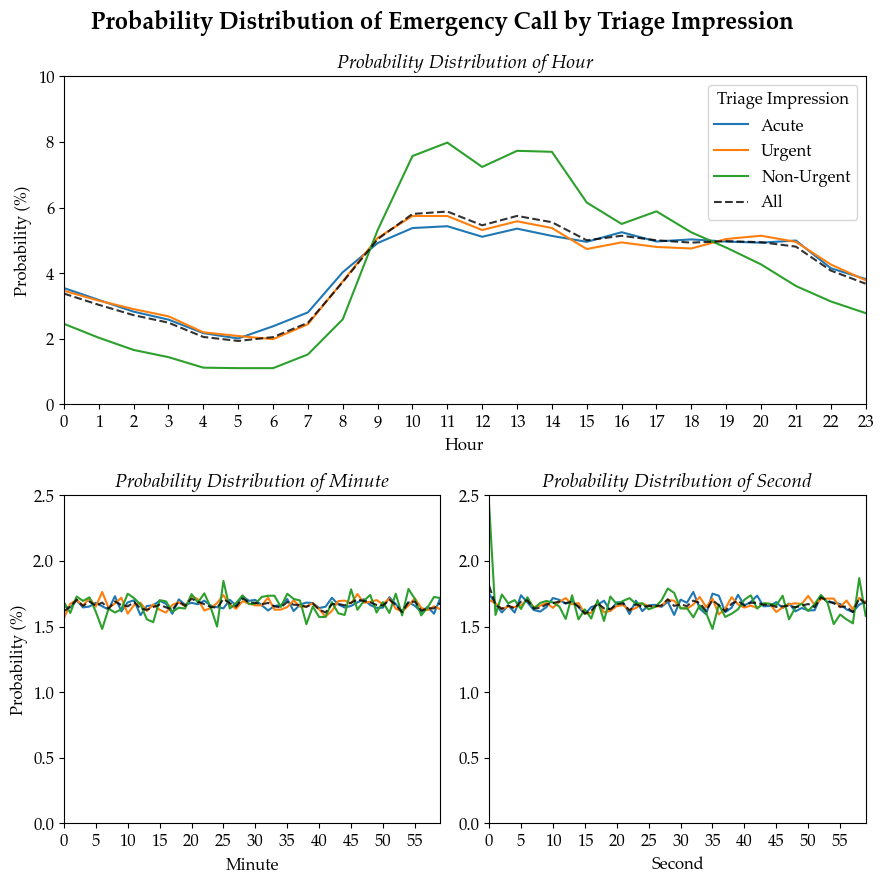

In [12]:
plot_time_distribution(dataframe)


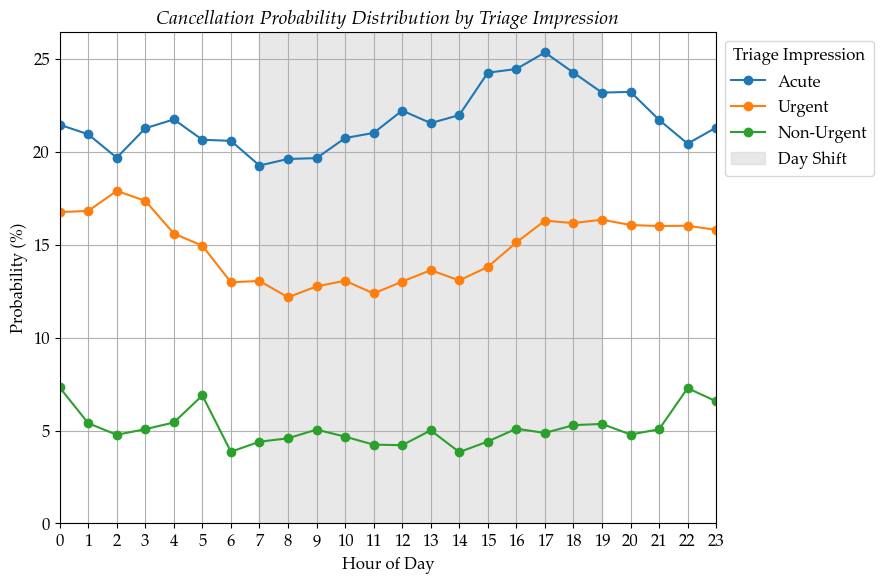

In [13]:
plot_cancellation_distribution(dataframe)


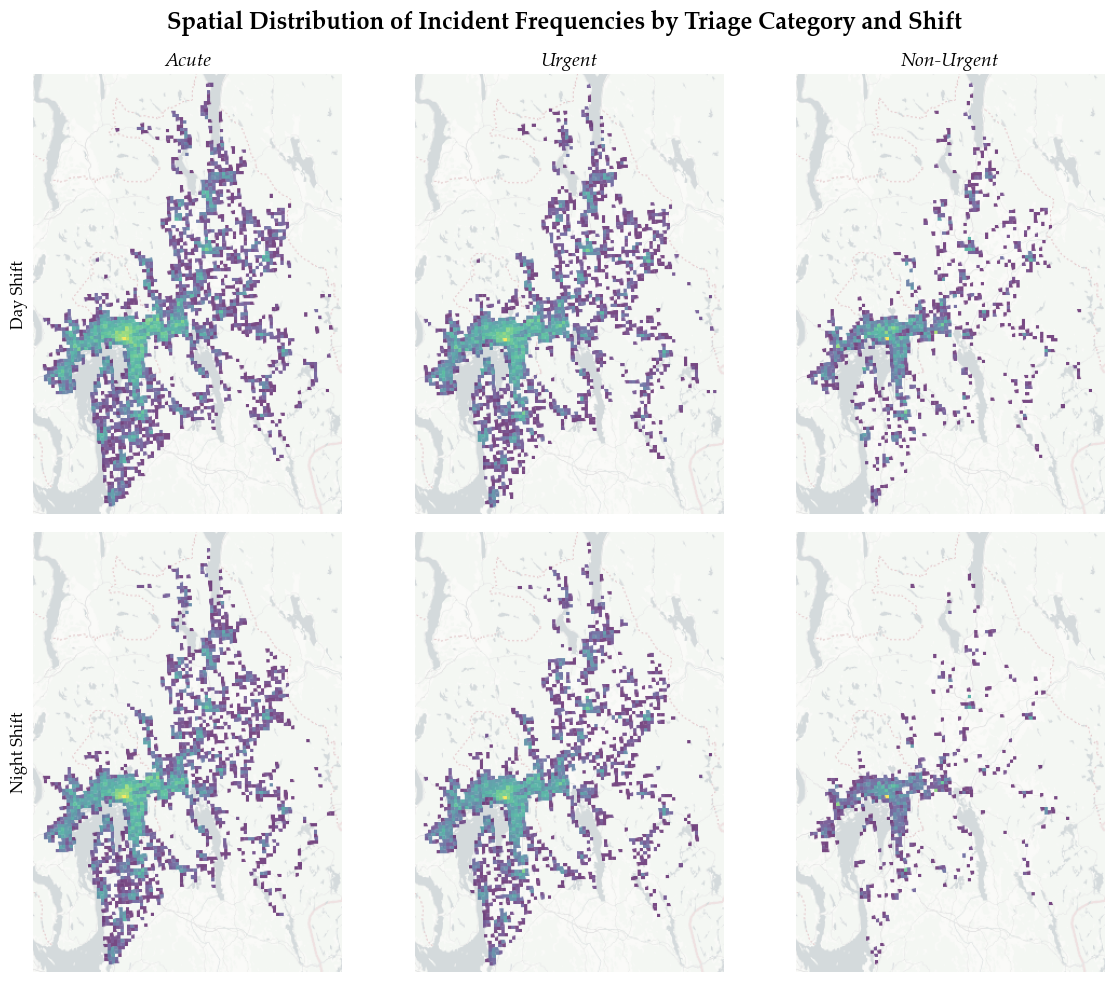

In [14]:
plot_incident_spatial_heatmap(dataframe)


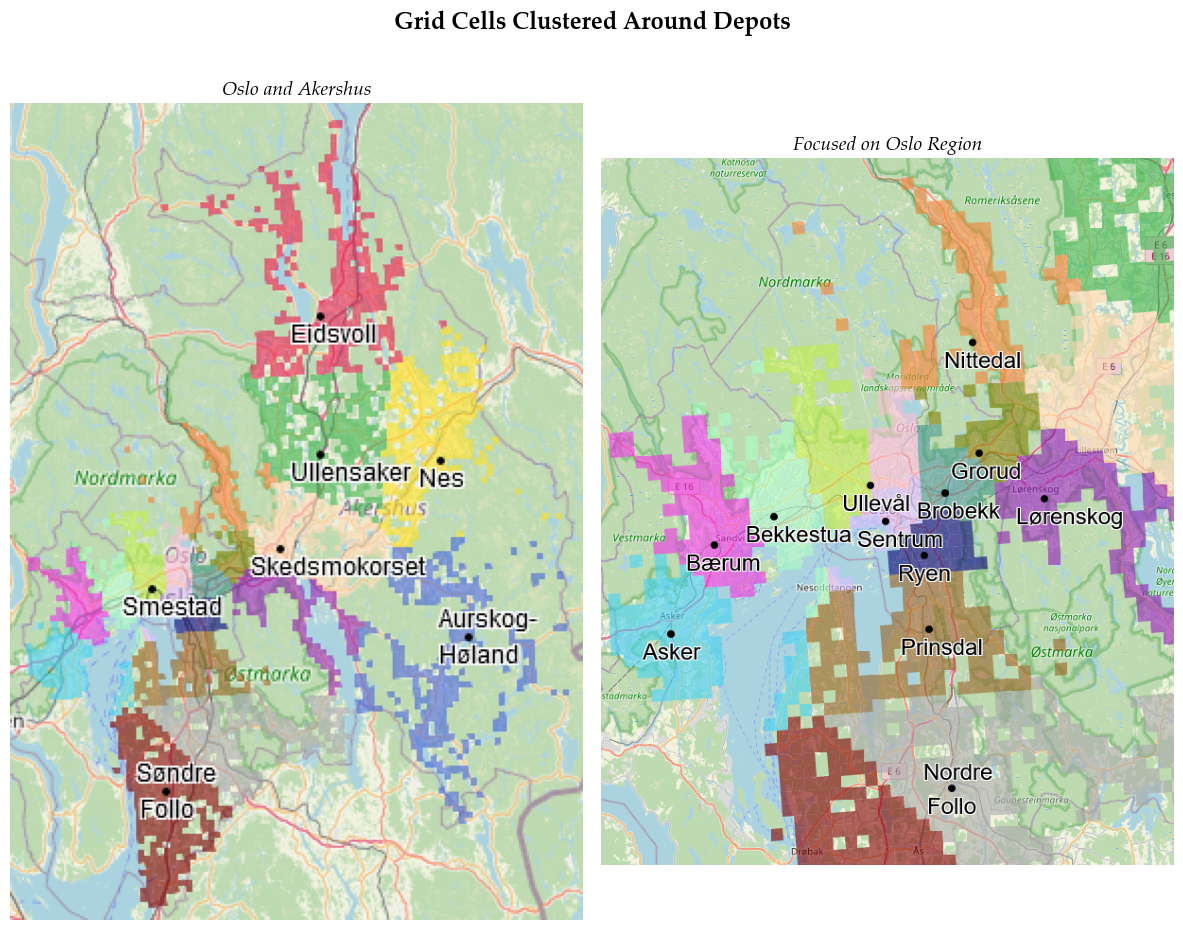

Eidsvoll: urban count 8.19%, non-urban count: 14.30%, compliance rate: 77.67%
Ullensaker: urban count 5.18%, non-urban count: 11.14%, compliance rate: 90.09%
Nes: urban count 3.68%, non-urban count: 12.87%, compliance rate: 86.85%
Aurskog-Høland: urban count 3.27%, non-urban count: 15.39%, compliance rate: 72.95%
Nittedal: urban count 1.50%, non-urban count: 3.56%, compliance rate: 87.67%
Lørenskog: urban count 7.50%, non-urban count: 3.33%, compliance rate: 78.76%
Asker: urban count 6.82%, non-urban count: 2.41%, compliance rate: 76.09%
Bærum: urban count 6.82%, non-urban count: 1.55%, compliance rate: 81.82%
Smestad: urban count 5.46%, non-urban count: 1.26%, compliance rate: 64.52%
Ullevål: urban count 2.59%, non-urban count: 0.52%, compliance rate: 89.29%
Brobekk: urban count 3.96%, non-urban count: 0.06%, compliance rate: 90.00%
Sentrum: urban count 3.00%, non-urban count: 0.06%, compliance rate: 73.91%
Prinsdal: urban count 6.68%, non-urban count: 3.79%, compliance rate: 75.65%
N

In [15]:
plot_cluster(dataframe)


In [16]:
df = data_loader.data_preprocessor.load_enhanced_depots_dataframe()

# Select the range of rows
df_subset = df.loc[0:18]

total_population = df_subset['total_incidents_cluster'].sum()

df.loc[0:18, "total_incidents_cluster_prob"] = (df_subset['total_incidents_cluster'] / total_population) * 100

# Display the updated DataFrame
print(df.loc[0:18, "total_incidents_cluster_prob"].mean())


5.263157894736842
